# BAYESIAN OPTIMIZATION ON TOP XGB

This notebook aims to introduce Bayesian Optimization as an alternative to traditional and very well known approaches like grid and random search. Bayesian Optimization can be used to optimize any black box function, which in this case will be the loss of a model as a function of the hyperparameters chosen.

Let's first import the libraries needed:

In [1]:
# Libraries needed
import pydotplus
import numpy as np
import pandas as pd
pd.options.display.max_columns = 30

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from matplotlib import pyplot

from scipy import stats
from scipy.stats.mstats import mquantiles

from datetime import datetime

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import datasets

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Dataset

The dataset that will be used is an anonymized version of a real world website activity tracker. Numeric features contain masked numbers whose statistical relationship has been preserved.

In [11]:
df = pd.read_csv('website-train.csv')
df.head()

,Date,CategoricalFeature1,CategoricalFeature2,Activity1,Activity2,Target,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,Activity13,Activity14,Activity15,Activity16
0,1/1/2015,Cat_1,Cat_1,NaN,4684.0,64.0,2388.0,4361.0,NaN,NaN,3917.0,NaN,1403.0,2514.0,5575.0,7475.0,3816.0,NaN,2894.0,NaN
1,1/1/2015,Cat_3,Cat_1,NaN,1247.0,71.0,611.0,1182.0,NaN,NaN,1061.0,NaN,408.0,723.0,1724.0,2440.0,1060.0,NaN,544.0,NaN
2,1/1/2015,Cat_1,Cat_10,NaN,962.0,59.0,617.0,1862.0,NaN,NaN,6623.0,NaN,365.0,399.0,1174.0,1679.0,750.0,NaN,292.0,NaN
3,1/1/2015,Cat_3,Cat_10,NaN,437.0,48.0,262.0,761.0,NaN,NaN,3075.0,NaN,158.0,222.0,415.0,656.0,340.0,NaN,167.0,NaN
4,1/1/2015,Cat_1,Cat_11,NaN,43.0,NaN,30.0,43.0,NaN,NaN,42.0,NaN,NaN,30.0,29.0,30.0,29.0,NaN,27.0,NaN


## Feature Engineering

Feature engineering in this use case will be simplified to retain the focus put on applying Bayesian Optimization. Only numeric features will be kept. Missing values will be kept in all cases. Missing observations in the target variable will be removed.

In [3]:
# Filtering out missing values in target and filling missings
df = df.dropna(subset = ['Target'])

to_drop = ['Date', 'CategoricalFeature1', 'CategoricalFeature2']
df = df.drop(to_drop, axis=1)

df.head()

,Activity1,Activity2,Target,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,Activity13,Activity14,Activity15,Activity16
0,NaN,4684.0,64.0,2388.0,4361.0,NaN,NaN,3917.0,NaN,1403.0,2514.0,5575.0,7475.0,3816.0,NaN,2894.0,NaN
1,NaN,1247.0,71.0,611.0,1182.0,NaN,NaN,1061.0,NaN,408.0,723.0,1724.0,2440.0,1060.0,NaN,544.0,NaN
2,NaN,962.0,59.0,617.0,1862.0,NaN,NaN,6623.0,NaN,365.0,399.0,1174.0,1679.0,750.0,NaN,292.0,NaN
3,NaN,437.0,48.0,262.0,761.0,NaN,NaN,3075.0,NaN,158.0,222.0,415.0,656.0,340.0,NaN,167.0,NaN
5,NaN,66192.0,485.0,16092.0,47437.0,NaN,NaN,47763.0,NaN,14012.0,41778.0,130170.0,171597.0,71765.0,NaN,41454.0,NaN


## Initial Steps

Before moving on, we need to separate our data set between X and y and then generate training and testing sets. Finally, the result of that will be encapsulated into XGB DMatrix:

In [4]:
# Defining X and y
X = df.drop('Target', axis=1)
y = df.Target

# Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Saving memory and moving datasets to the xgb structure
del(df)

dtrain = xgb.DMatrix(X_train, label=y_train)
del(X_train)

dtest = xgb.DMatrix(X_test)
del(X_test)

## Applying Bayesian Optimization

A visual demo of how Bayesian Optimization works can be found below. We are going to replicate this idea with our data set. To add some context, we are going to use XGBRegressor as our main prediction model. A priori, we cannot have certainty about which could be the optimal combination of hyperparameters. We do have some guidance about which hyperparameter ranges could lead to better results, but finding the optimal combination of them is impossible in practice without taking a smarter approach.

![SegmentLocal](bayesian.gif "segment")

First, we are going to define a function that will take all the hyperparameters we are going to optimize after. We will use that set of parameters and our previously created DMatrix to apply cross validation with 3 folds. Bayesian Optimization is a maximizer so we need to do a minor tweaking for it to minimize our loss function.

In [5]:
def xgb_evaluate(max_depth, learning_rate, gamma, min_child_weight, colsample_bytree):
    
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'learning_rate': float(learning_rate),
              'gamma': float(gamma),
              'min_child_weight': int(min_child_weight),
              'colsample_bytree': float(colsample_bytree),
              'subsample': 0.8,}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

At this stage, optimization can begin (performance is the y of the function and the idea is to minimize error). We are going to define ranges of values for each hyperparameter:

In [6]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 11),
                                             'learning_rate': (0.05, 0.5),
                                             'gamma': (0, 1),
                                             'min_child_weight': (1, 10),
                                             'colsample_bytree': (0.4, 0.8)})

# Use the expected improvement acquisition function to handle negative numbers
# init and iter can be lower
xgb_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... |
-------------------------------------------------------------------------------------
|  1        | -102.5    |  0.4548   |  0.3899   |  0.1097   |  3.514    |  3.287    |
|  2        | -106.3    |  0.5647   |  0.6391   |  0.3519   |  4.817    |  9.787    |
|  3        | -104.7    |  0.4763   |  0.9871   |  0.219    |  10.94    |  5.603    |
|  4        | -103.4    |  0.5876   |  0.2525   |  0.2667   |  3.266    |  3.622    |
|  5        | -103.2    |  0.7448   |  0.3726   |  0.2761   |  6.674    |  1.004    |
|  6        | -105.3    |  0.6391   |  0.1182   |  0.3183   |  6.538    |  4.849    |
|  7        | -105.8    |  0.7893   |  0.3463   |  0.4129   |  3.338    |  9.899    |
|  8        | -103.2    |  0.626    |  0.4017   |  0.2722   |  4.585    |  3.514    |
|  9        | -102.1    |  0.6956   |  0.8114   |  0.2432   |  4.781    |  5.785    |
|  10       | -103.9    |  0.4144   |  0.1222   |  0.2

|  58       | -102.2    |  0.7235   |  0.9693   |  0.1772   |  5.25     |  2.195    |
|  59       | -102.0    |  0.7211   |  0.7929   |  0.1322   |  10.07    |  4.748    |
|  60       | -101.1    |  0.7642   |  0.7061   |  0.1454   |  5.874    |  9.938    |


In [7]:
# Get the best params from bayesian
params = xgb_bo.max['params']

# Set to int if floats
params['max_depth'] = int(params['max_depth'])
params['min_child_weight'] = int(params['min_child_weight'])

print(params)

{'colsample_bytree': 0.7418139052555597, 'gamma': 0.7110264022048283, 'learning_rate': 0.06635929713655503, 'max_depth': 9, 'min_child_weight': 4}


The result of the optimization process is a set of optimal hyperparameters. That is, the hyperparameters that through Bayesian Optimization were found as the ones minimizing the loss.

## Training With Optimal Hyperparameters

As the optimal hyperparameters are now known, let's use them to train our model:

In [8]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=250)

# Predict on testing and training set
y_pred = model.predict(dtest)
y_train_pred = model.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

98.73812986706827
35.65469181340354


As an additional step, fscores for each predictor can be displayed:

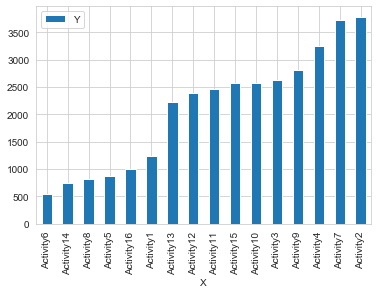

In [9]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X');

## Testing Over Holdout Set

Up to this stage, we have run our procedure using a single data set that was separated into training and testing frames. A mandatory and final step to corroborate that results can be generalized is to introduce a holdout set with observations the model has never seen:

In [15]:
eval_set = pd.read_csv('website-eval.csv')
eval_set.head()

,Date,CategoricalFeature1,CategoricalFeature2,Activity1,Activity2,Target,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,Activity13,Activity14,Activity15,Activity16
0,7/1/2018,Cat_1,Cat_1,2102.0,3115.0,52.0,2362.0,1566.0,56.0,NaN,NaN,60.0,507.0,1031.0,2958.0,2999.0,1800.0,2756.0,1038.0,81.0
1,7/1/2018,Cat_2,Cat_1,995.0,801.0,39.0,941.0,646.0,NaN,NaN,NaN,78.0,72.0,310.0,810.0,1123.0,574.0,868.0,214.0,NaN
2,7/1/2018,Cat_4,Cat_1,3209.0,2617.0,40.0,3643.0,1292.0,62.0,NaN,NaN,248.0,288.0,583.0,2094.0,2301.0,1342.0,1904.0,202.0,48.0
3,7/1/2018,Cat_1,Cat_10,345.0,968.0,NaN,457.0,842.0,NaN,NaN,NaN,102.0,209.0,817.0,1174.0,1553.0,823.0,1395.0,185.0,62.0
4,7/1/2018,Cat_2,Cat_10,182.0,196.0,45.0,270.0,435.0,NaN,NaN,NaN,66.0,61.0,799.0,695.0,857.0,483.0,706.0,119.0,NaN


Same preprocessing steps will be applied to the holdout set:

In [16]:
# Filtering out missing values in target and filling missings
eval_set = eval_set.dropna(subset = ['Target'])

to_drop = ['Date', 'CategoricalFeature1', 'CategoricalFeature2']
eval_set = eval_set.drop(to_drop, axis=1)

eval_set.head()

,Activity1,Activity2,Target,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,Activity13,Activity14,Activity15,Activity16
0,2102.0,3115.0,52.0,2362.0,1566.0,56.0,NaN,NaN,60.0,507.0,1031.0,2958.0,2999.0,1800.0,2756.0,1038.0,81.0
1,995.0,801.0,39.0,941.0,646.0,NaN,NaN,NaN,78.0,72.0,310.0,810.0,1123.0,574.0,868.0,214.0,NaN
2,3209.0,2617.0,40.0,3643.0,1292.0,62.0,NaN,NaN,248.0,288.0,583.0,2094.0,2301.0,1342.0,1904.0,202.0,48.0
4,182.0,196.0,45.0,270.0,435.0,NaN,NaN,NaN,66.0,61.0,799.0,695.0,857.0,483.0,706.0,119.0,NaN
5,973.0,2331.0,81.0,2065.0,2563.0,45.0,NaN,NaN,629.0,301.0,9055.0,6802.0,9827.0,4473.0,8822.0,647.0,46.0


In [17]:
X = eval_set.drop('Target',axis=1)
y = eval_set.Target

deval = xgb.DMatrix(X, label=y)

Now finally predicting and evaluating performance over the holdout set. Results are pretty much in line with what we saw earlier:

In [18]:
y_pred_eval = model.predict(deval)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y, y_pred_eval)))

63.98674648799667


In [19]:
holdout = pd.DataFrame({'Target_True': y, 'Target_Pred': y_pred_eval})

holdout.to_csv('predictions.csv', index=False)